### U-net with simple Resnet Blocks v2, can get 0.80+
* Original version : 
  https://www.kaggle.com/shaojiaxin/u-net-with-simple-resnet-blocks
        
        
#### update log
1.   Cancel last dropout (seems better)
2.  modify convolution_block, to be more consistant with the standard resent model. 
      * https://arxiv.org/abs/1603.05027
3. Use faster  IOU metric score code,
      * https://www.kaggle.com/donchuk/fast-implementation-of-scoring-metric
4. Use  binary_crossentropy loss and then Lovász-hinge loss (very slow!)
     * Lovász-hinge loss: https://github.com/bermanmaxim/LovaszSoftmax
     
Limit the max epochs number to make the kernel finish in the limit of 6 hours, better score can be achived at more epochs 

In [1]:
import os
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add,SpatialDropout2D
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers
from keras.utils import multi_gpu_model

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img

import time
t_start = time.time()


# 指定需要使用的gpu，编号从0开始，多块gpu用逗号分隔
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"# "0", "0, 1"

# 占用百分之十的显存上限
import tensorflow as tf
import keras.backend as K
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.95, allow_growth =True)#0.95
sess = tf.Session(config = tf.ConfigProto(gpu_options = gpu_options))
K.set_session(sess)

/home/endi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
SEED = 1234
save_model_name = "model/0915_unet_seed%d_epoch100_lr005_size128.model"%SEED
sub_name = "submissions/0915_unet_seed%d_epoch100_lr005_size128.csv.gz"%SEED

In [3]:
#import pandas as pd
#train_df = pd.read_csv("data/raw/train.csv", index_col="id", usecols=[0])

# img_size_ori = 101
# img_size_target = 128

# def upsample(img):# img_size_ori=img_size_target: identity
#     if img_size_ori == img_size_target:
#         return img
#     return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)

train_df.images.map(upsample)


In [4]:
img_size_ori = 101
img_size_target = 101

def upsample(img):# img_size_ori=img_size_target: identity
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)


# Loading of training/testing ids and depths
train_df = pd.read_csv("data/raw/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("data/raw/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

print(len(train_df), len(test_df))

# #Plotting the depth distributions
# sns.distplot(train_df.z, label="Train")
# sns.distplot(test_df.z, label="Test")
# plt.legend()
# plt.title("Depth distribution")

# Loading images into numpy array
train_df["images"] = [np.array(load_img("data/raw/train_images/images/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]
train_df["masks"] = [np.array(load_img("data/raw/train_images/masks/{}.png".format(idx), color_mode = "grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]


4000 18000


In [5]:
train_df["coverage"] = train_df.masks.map(np.sum) / img_size_ori**2

def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

#Plotting the coverage-quantile distributions
# fig, axs = plt.subplots(1, 2, figsize=(15,5))
# sns.distplot(train_df.coverage, kde=False, ax=axs[0])
# sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
# plt.suptitle("Salt coverage")
# axs[0].set_xlabel("Coverage")
# axs[1].set_xlabel("Coverage class")

In [11]:
# Create train/validation split stratified by salt coverage
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    # for keras
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=SEED)

#Data augmentation
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
print(x_train.shape)
print(y_valid.shape)

(6400, 101, 101, 1)
(800, 101, 101, 1)


In [1]:
import pickle
with open('data/processed/dataset_%d.pkl'%SEED, 'wb') as f:
    pickle.dump([ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test], f)

#with open('data/processed/dataset_%d.pkl'%SEED, 'rb') as f:
#    ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = pickle.load(f)
print(x_train.shape)
print(y_valid.shape)

NameError: name 'SEED' is not defined

## fitting unet

In [7]:
# from importlib import reload
# import unet2
# reload(unet2)

#from unet import *
#from unet2 import *

from metrics import *
img_size_ori = 101
img_size_target = 101#128

In [1]:
from keras_contrib_resnet import ResNet34

resnet = ResNet34(input_shape=(224,224,1), classes=2)
resnet

/home/endi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...
reshaping via a convolution...


In [9]:
resnet.load_weights(filepath='bin/resnet34_imagenet_1000.h5')
#resnet.layers

ValueError: You are trying to load a weight file containing 73 layers into a model with 75 layers.

In [11]:
# model
input_layer = Input((img_size_target, img_size_target, 1))
output_layer = build_model(input_layer, 16, 0.5)
model1 = Model(input_layer, output_layer)
#model1 = build_model(img_size_target=128)

#model1 = multi_gpu_model(model1, gpus=2, cpu_merge=True, cpu_relocation=False)# multi-gpu version

c = optimizers.adam(lr = 0.01)
model1.compile(loss="binary_crossentropy", optimizer=c, metrics=[my_iou_metric])

#model1.summary()

In [11]:
%%time
#early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name,monitor='my_iou_metric', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='my_iou_metric', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)

epochs = 50
batch_size = 32
history = model1.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/2
6400/6400 [==============================] - 37s 6ms/step - loss: 4.0056 - my_iou_metric: 0.3889 - val_loss: 3.9942 - val_my_iou_metric: 0.3900

Epoch 00001: my_iou_metric improved from -inf to 0.38891, saving model to model/0915_unet_seed1234_epoch100_lr005_size128.model
Epoch 2/2
6400/6400 [==============================] - 25s 4ms/step - loss: 3.9810 - my_iou_metric: 0.3906 - val_loss: 3.9942 - val_my_iou_metric: 0.3900

Epoch 00002: my_iou_metric improved from 0.38891 to 0.39062, saving model to model/0915_unet_seed1234_epoch100_lr005_size128.model
CPU times: user 1min 59s, sys: 5.51 s, total: 2min 4s
Wall time: 1min 45s


In [12]:
# remove layter activation layer and use losvasz loss
model1 = load_model(save_model_name, custom_objects={'my_iou_metric': my_iou_metric})
input_x = model1.layers[0].input
output_layer = model1.layers[-1].input
model = Model(input_x, output_layer)
#model = load_model(save_model_name, custom_objects={'my_iou_metric': my_iou_metric_2})
#model = build_model(img_size_target=128)

c = optimizers.adam(lr = 0.01)
# lovasz_loss need input range (-∞，+∞), so cancel the last "sigmoid" activation  
# Then the default threshod for pixel prediction is 0 instead of 0.5, as in my_iou_metric_2.
model.compile(loss=lovasz_loss, optimizer=c, metrics=[my_iou_metric_2])

#model.summary()

In [13]:
# %%time
early_stopping = EarlyStopping(monitor='val_my_iou_metric_2', mode = 'max',patience=20, verbose=1)
model_checkpoint = ModelCheckpoint(save_model_name, monitor='val_my_iou_metric_2', 
                                   mode = 'max', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric_2', mode = 'max',factor=0.5, patience=5, min_lr=0.0001, verbose=1)
epochs = 50
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[model_checkpoint,reduce_lr,early_stopping], 
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/50
2336/6400 [=========>....................] - ETA: 1:22 - loss: 47881960046.8518 - my_iou_metric_2: 0.2780

KeyboardInterrupt: 

In [ ]:
fig, (ax_loss, ax_score) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_score.plot(history.epoch, history.history["my_iou_metric_2"], label="Train score")
ax_score.plot(history.epoch, history.history["val_my_iou_metric_2"], label="Validation score")
ax_score.legend()

## some post-process to select best threshold

In [8]:
from postprocess import *

In [9]:
def predict_proba(save_model_name):
    model = load_model(save_model_name, custom_objects={'my_iou_metric_2': my_iou_metric_2,
                                                        'lovasz_loss': lovasz_loss})
    threshold_best, iou_best = get_best_threshold(x_valid, y_valid, img_size_target, model, plot=True)
    x_test = np.array([(np.array(load_img("data/raw/test_images/images/{}.png".format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)
    preds_test = predict_result(model,x_test,img_size_target)
    return preds_test, threshold_best, iou_best


[0.811    0.81275  0.81425  0.81575  0.816125 0.81675  0.817    0.817
 0.81875  0.81925  0.819125 0.8195   0.81925  0.8185   0.818375 0.8175
 0.82275  0.822625 0.8225   0.823    0.822875 0.822625 0.82225  0.821875
 0.82125  0.82     0.819375 0.81925  0.81875  0.81725  0.815875]


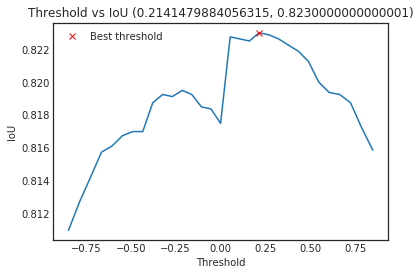

In [34]:
SEED = 3456
save_model_name = "model/unet_seed%d_epoch100.model"%SEED
sub_name = "submissions/0910_unet080_seed%d_epoch100.csv.gz"%SEED

preds_test, threshold_best, iou_best = predict_proba(save_model_name)

In [20]:
## for single model submission
pred_dict = {idx: rle_encode(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub = sub.reset_index().rename(columns={'index':'id', 0:'rle_mask'})

#print(sub_name)
sub.to_csv(sub_name, compression='gzip', index=False)

In [10]:
## TODO: for 5-fold-cv models, blend probability preds here (Note each model has specific threshold_best)
pred = []

In [15]:
_pred = np.round(preds_test > threshold_best)
pred.append(_pred)

In [16]:
preds_test_blend = np.round((pred[0] + pred[1] + pred[2]) / 3 > 0.5)

In [17]:
# convert to rle_mask format and submit
pred_dict = {idx: rle_encode(downsample(preds_test_blend[i])) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub = sub.reset_index().rename(columns={'index':'id', 0:'rle_mask'})

In [18]:
sub.to_csv('submissions/0910_unet080_seed_epoch100_3fold_blend.csv.gz', compression='gzip', index=False)

In [19]:
sub

,id,rle_mask
0,353e010b7b,
1,5439dbbddf,
2,71bab9f311,
3,52551f7a80,
4,512d8d9997,3250 4 3349 8 3449 13 3550 15 3651 17 3751 24 ...
5,64dba827d6,
6,0a3a8a5f37,
7,329563756f,1 5251 5253 100 5354 98 5455 98 5556 97 5657 9...
8,f6cba2e890,
9,989c646373,
